In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import trt_pose.coco
import math
import os
import numpy as np
import traitlets
import pickle 


In [2]:
with open('preprocess/hand_pose.json', 'r') as f:
    hand_pose = json.load(f)

topology = trt_pose.coco.coco_category_to_topology(hand_pose)
import trt_pose.models

num_parts = len(hand_pose['keypoints'])
num_links = len(hand_pose['skeleton'])

model = trt_pose.models.resnet18_baseline_att(num_parts, 2 * num_links).cuda().eval()
import torch


WIDTH = 224
HEIGHT = 224
data = torch.zeros((1, 3, HEIGHT, WIDTH)).cuda()

if not os.path.exists('model/hand_pose_resnet18_att_244_244_trt.pth'):
    MODEL_WEIGHTS = 'model/hand_pose_resnet18_att_244_244.pth'
    model.load_state_dict(torch.load(MODEL_WEIGHTS))
    import torch2trt
    model_trt = torch2trt.torch2trt(model, [data], fp16_mode=True, max_workspace_size=1<<25)
    OPTIMIZED_MODEL = 'model/hand_pose_resnet18_att_244_244_trt.pth'
    torch.save(model_trt.state_dict(), OPTIMIZED_MODEL)


OPTIMIZED_MODEL = 'model/hand_pose_resnet18_att_244_244_trt.pth'
from torch2trt import TRTModule

model_trt = TRTModule()
model_trt.load_state_dict(torch.load(OPTIMIZED_MODEL))

<All keys matched successfully>

In [3]:
from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects

parse_objects = ParseObjects(topology,cmap_threshold=0.12, link_threshold=0.15)
draw_objects = DrawObjects(topology)

In [4]:

import torchvision.transforms as transforms
import PIL.Image

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
device = torch.device('cuda')

def preprocess(image):
    global device
    device = torch.device('cuda')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf'))

In [6]:
from preprocessdata import preprocessdata
preprocessdata = preprocessdata(topology, num_parts)

In [7]:
svm_train = False
if svm_train:
    clf, predicted = preprocessdata.trainsvm(clf, joints_train, joints_test, hand.labels_train, hand.labels_test)
    filename = 'svmmodel.sav'
    pickle.dump(clf, open(filename, 'wb'))
else:
    filename = 'svmmodel.sav'
    clf = pickle.load(open(filename, 'rb'))

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
from jetcam.usb_camera import USBCamera
from jetcam.csi_camera import CSICamera
from jetcam.utils import bgr8_to_jpeg

camera = USBCamera(width=WIDTH, height=HEIGHT, capture_fps=30, capture_device=0)
#camera = CSICamera(width=WIDTH, height=HEIGHT, capture_fps=30)

camera.running = True

In [9]:
def draw_joints(image, joints):
    count = 0
    for i in joints:
        if i==[0,0]:
            count+=1
    if count>= 7:
        return 
    for i in joints:
        cv2.circle(image, (i[0],i[1]), 2, (0,0,255), 1)
    cv2.circle(image, (joints[0][0],joints[0][1]), 2, (255,0,255), 1)
    for i in hand_pose['skeleton']:
        if joints[i[0]-1][0]==0 or joints[i[1]-1][0] == 0:
            break
        cv2.line(image, (joints[i[0]-1][0],joints[i[0]-1][1]), (joints[i[1]-1][0],joints[i[1]-1][1]), (0,255,0), 1)

In [10]:
with open('preprocess/gesture.json', 'r') as f:
    gesture = json.load(f)
gesture_type = gesture["paint"]

In [11]:
pen = []
rectangle = []
def draw(image, joints):
    global pen
    global rectangle
    if preprocessdata.text=="draw":
        pen.append((joints[6][0], joints[6][1]))
    for i in range(len(pen)):
        cv2.circle(image, pen[i], 1,(0,0,0), 2)
    if preprocessdata.text=="line":
        if joints[5]!=[0,0]:
            rectangle.append((joints[6][0], joints[6][1]))
    for i in range(len(rectangle)):
        if i > 0:
            if rectangle[i]!=[0,0]:
                cv2.line(image,rectangle[i-1], rectangle[i], (0,0,0), 2)
    
    '''if preprocessdata.text=="line":
        if joints[5]!=[0,0]:
            rectangle.append((joints[6][0], joints[6][1]))
    for i in range(len(rectangle)):
        if i > 0:
            if rectangle[i]!=[0,0]:
                cv2.line(image,rectangle[i-1], rectangle[i], (255,255,255), 5)
    '''
    
    if preprocessdata.text=="erase":
        to_be_erased = []
        for i in range(10):
            for j in range(10):
                
                x = (joints[6][0]+i, joints[6][1]+j)
                if x[0]>=0 or x[1]>=0:
                    to_be_erased.append(x)
        for i in to_be_erased:
            if i in pen:
                pen.remove(i)           
            
    if preprocessdata.text=="clear":
        pen.clear()
        rectangle.clear()

In [12]:
rectangle_2 = []
def draw_in_WB(image,joint):
    if preprocessdata.text=="line":
        if joints[5]!=[0,0]:
            rectangle_2.append((joints[6][0], joints[6][1]))

    if (len(rectangle)) > 0:
        if rectangle[-1]!=[0,0]:
            cv2.line(image,rectangle[-2], rectangle[-1], (0,0,0), 2)

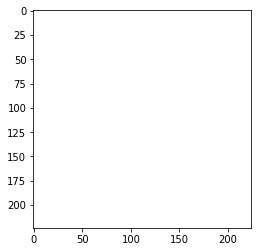

"def update(i, img):\n    if i != 0:\n        plt.cla()\n    plt.imshow(img)\n    \nfig = plt.figure(figsize=(10, 10))\nani = anm.FuncAnimation(fig, update, fargs = ('Initial Animation! ', 2.0),     interval = 100, frames = 132)"

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm

img_white = np.full((224,224,3), 255, np.uint8)
plt.imshow(img_white)
plt.show()

'''def update(i, img):
    if i != 0:
        plt.cla()
    plt.imshow(img)
    
fig = plt.figure(figsize=(10, 10))
ani = anm.FuncAnimation(fig, update, fargs = ('Initial Animation! ', 2.0), \
    interval = 100, frames = 132)'''

In [14]:
import ipywidgets
from IPython.display import display


image_w = ipywidgets.Image(format='jpeg', width=224, height=224)
display(image_w)

Image(value=b'', format='jpeg', height='224', width='224')

In [15]:
def execute(change):
    image = change['new']
    data = preprocess(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    counts, objects, peaks = parse_objects(cmap, paf)
    joints = preprocessdata.joints_inference(image, counts, objects, peaks)
    #draw_objects(image, counts, objects, peaks )
    draw_joints(image, joints)
    dist_bn_joints = preprocessdata.find_distance(joints)
    gesture = clf.predict([dist_bn_joints,[0]*num_parts*num_parts])
    gesture_joints = gesture[0]
    preprocessdata.prev_queue.append(gesture_joints)
    preprocessdata.prev_queue.pop(0)
    preprocessdata.print_label(image, preprocessdata.prev_queue, gesture_type)
    draw(image, joints)
    draw_in_WB(img_white, joints)
    #image = image[:, ::-1, :]
    image_w.value = bgr8_to_jpeg(image)
    plt.imshow(img_white)
    plt.show()
    plt.clf()
    


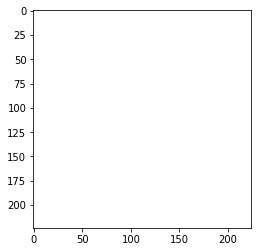

In [16]:
execute({'new': camera.value})

In [ ]:
camera.observe(execute, names='value')

In [18]:
camera.unobserve_all()

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/jetcam-0.0.0-py3.6.egg/jetcam/camera.py", line 34, in _capture_frames
    self.value = self._read()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/usr/local/lib/python3.6/dist-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/usr/local/lib/python3.6/dist-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/usr/local/lib/python3.6/dist-packages/traitlets/traitlets.py", line 1176, in notify_change
    c(change)
  File "<ipython-input-15-8ae0f618710f>", line 20, in execute
    plt.imshow(img_white)
  File "/usr/

In [ ]:
camera.running = False